# Bag of Visual Words - Build a simple google images retrieval system

This notebook is derived and inspired from https://www.pinecone.io/learn/series/image-search/bag-of-visual-words/

CHECK THE BEGINNING OF THE ORIGINAL NOTEBOOK IF YOUA INTERESTED IN A DETAILED EXPLAINATION ABOUT BAG OF VISUAL WORDS.

## What is Bag of Visual Words?

In computer vision, **bag of visual words (BoVW)** is one of the pre-deep learning models used for *object recognition*. This includes finding images in a database that are similar to a given query image, or contains the same objects, or finding an already visited place for loop closure detection (the latter is very important for SLAM - Simultaneous Localization and Mapping).

In this notebook, you don't have to modify much of the code. You may want to improve the accuracy of this simple bag of words demo, by experimenting with the SIFT extractor parameters and the K-mean clustering. You can also play with the brightness and warping transformations of the query images to make things more interestings (but if you abuse the transformations, this simple exercise demo will fail to retrieve similar images).

## Implementing Bag of Visual Words

In [1]:
# JUST RUN THIS CELL

%load_ext autoreload
%autoreload 2

%matplotlib inline

import cv2 # opencv is a computer vision library
import numpy as np # numpy is a library for numerical computing
from matplotlib import pyplot as plt # matplotlib is a plotting library
from IPython import display
from pathlib import Path
import tqdm
np.random.seed(0)  # for reproducibility
import glob
import sys

sys.path.append('..')
import utils
from utils import show_image, show_images, warp_perspective, kmeans

images_path = Path('image_database')

# JUST RUN THIS CELL

utils.CV2_MAX_IMAGE_HEIGHT = 1080/2  # set a maximum height for cv2 image visualization
utils.SHOW_IMAGE_BACKEND = utils.Backend.PLT  # set the default backend for visualization

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Training Dataset Load and Cleaning

First, we want to import a dataset of images to train the model. I have personally built this small dataset (~70 images) composed of 6 classes: *alps*, *fushimi_inari*, *giza_pyramid*, *hagia_sophia*, *petronas_towers*, *tour_eiffel*, downloading free stock images from internet.

In [2]:
# JUST RUN THIS CELL

database = {}  # dictionary to store images and related data

print(f"Images path: {images_path}")

images_classes = list(sorted(glob.glob(str(images_path / '**'))))


print(f"Found {len(images_classes)} images classes")

tqdm_list = tqdm.tqdm(images_classes)
for image_class_folder in tqdm_list:
	folder_name = Path(image_class_folder).name
	desc = f"Loading images from class '{folder_name}'"
	tqdm_list.set_description(f"Processing {tqdm_list.n + 1}/{len(tqdm_list)}: {folder_name}")
	database[folder_name] = []
	images = list(sorted(glob.glob(str(Path(image_class_folder) / '*.jpg'))))
	for image_path in images:
		image_name = Path(image_path).name
		image = cv2.imread(image_path)
		# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert BGR to RGB
		# database[folder_name][image_name] = {
		database[folder_name].append(image)


Images path: image_database
Found 6 images classes


Processing 6/6: tour_eiffel: 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]    


You can visualise some of the images below.

dict_keys(['alps', 'fushimi_inari', 'giza_pyramid', 'hagia_sophia', 'petronas_towers', 'tour_eiffel'])


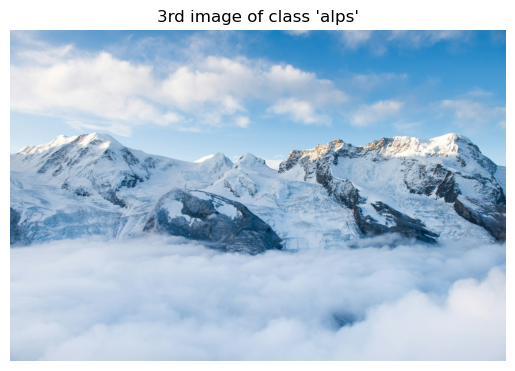

In [3]:
### CHOOSE WHICH CLASS AND IMAGE TO VISUALIZE
CLASS_IDX = 0  # Chose the class to visualize
IMAGE_IDX = 3  # Chose the image index to visualize
######################################

print(database.keys())

if CLASS_IDX >= len(database):
	raise ValueError(f"CLASS_IDX {CLASS_IDX} is out of range, database has {len(database)} classes")

first_class = list(database.keys())[CLASS_IDX]

if IMAGE_IDX >= len(database[first_class]):
	raise ValueError(f"IMAGE_IDX {IMAGE_IDX} is out of range, class '{first_class}' has {len(database[first_class])} images")

first_image_class = database[first_class][IMAGE_IDX]

show_image(first_image_class,
	title=f"{IMAGE_IDX}{'st' if IMAGE_IDX == 1 else 'nd' if IMAGE_IDX == 2 else 'rd' if IMAGE_IDX == 3 else 'th'}"
	f" image of class '{first_class}'")

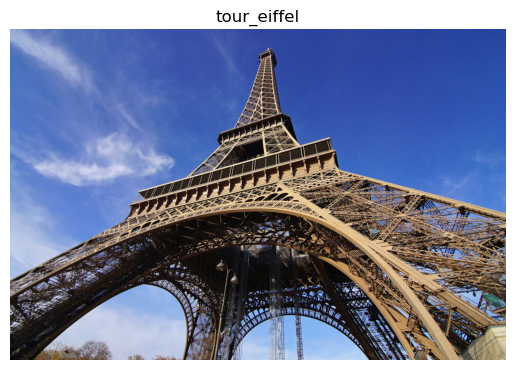

Displaying class 6/6 'tour_eiffel': 100%|██████████| 6/6 [00:14<00:00,  2.43s/it]    


In [4]:
# OPTIONAL, run this cell to visualize all images in the dataset one by one

import time

from IPython import display

MS_PER_FRAME = 1  # milliseconds per frame

def pltsin(ax, image, hdisplay, title=""):
	ax.clear()
	ax.axis('off')
	ax.set_title(title)
	ax.imshow(image)
	hdisplay.update(fig)


fig,ax = plt.subplots(1,1)
hdisplay = display.display("", display_id=True)

ax.set_xlabel('X')
ax.set_ylabel('Y')
tqdm_obj = tqdm.tqdm(database.keys())
for class_name in tqdm_obj:
	class_images = database[class_name]
	tqdm_obj.set_description(f"Displaying class {tqdm_obj.n + 1}/{len(tqdm_obj)} '{class_name}'")
	for image in class_images:
		pltsin(ax, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), title=class_name, hdisplay=hdisplay)
		time.sleep(0.01)

plt.close(fig)

Now let's resize the images to speed up the Visual Words database creation (bigger images means more features, slowing down the database creation. Of course, you could also just limit the amount of features extracted from each image).

In [5]:
# JUST RUN THIS CELL

APPLY_SMOOTHING = False  # whether to smooth images to reduce noise
MAX_NUMBER_OF_PIXELS = 1920 * 1080 / 8  # maximum number of pixels for each image

# generate an array from the original dataset
images_training = []

for class_name in tqdm.tqdm(database.keys(), desc="Generating training images array"):
	class_images = database[class_name]
	for n in range(len(class_images)):
		image = class_images[n].copy()
		height, width = image.shape[:2]
		num_pixels = height * width
		if num_pixels > MAX_NUMBER_OF_PIXELS:
			scale_factor = (MAX_NUMBER_OF_PIXELS / num_pixels) ** 0.5
			new_width = int(width * scale_factor)
			new_height = int(height * scale_factor)
			image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
		if APPLY_SMOOTHING:
			image = cv2.GaussianBlur(image, (5, 5), 0)

		images_training.append(image)

Generating training images array: 100%|██████████| 6/6 [00:00<00:00, 23.97it/s]


We have now a dataset of images that we can use to train our model. Let's see how to build it.

### Visual features Extraction

The first step is to extract the image visual features (keypoints and descriptors). We will use SIFT, since as you learnt in the previous notebooks, is a robust and consistent feature detector and descriptor. Remember, it is robust to scale and brightness transformations, rotations, and viewpoint changes.

In [6]:
### YOU CAN ADJUST SIFT PARAMETERS HERE IF NEEDED
SIFT_N_FEATURES = None
SIFT_N_OCTAVE_LAYERS = 5
SIFT_CONTRAST_THRESHOLD = 0.04
SIFT_EDGE_THRESHOLD = 20
SIFT_SIGMA = 2.0
#######################################

# initialize lists where we will store *all* keypoints and descriptors
keypoints = []
descriptors = []

sift_extractor = cv2.SIFT_create(
	nfeatures=SIFT_N_FEATURES,
	nOctaveLayers=SIFT_N_OCTAVE_LAYERS,
	contrastThreshold=SIFT_CONTRAST_THRESHOLD,
	edgeThreshold=SIFT_EDGE_THRESHOLD,
	sigma=SIFT_SIGMA
)

for img in tqdm.tqdm(images_training):
    # extract keypoints and descriptors for each image
    img_keypoints, img_descriptors = sift_extractor.detectAndCompute(img, None)
    if img_descriptors is not None:
        keypoints.append(img_keypoints)
        descriptors.append(img_descriptors)

100%|██████████| 73/73 [00:02<00:00, 34.44it/s]


Now that we have extracted the features, we can visualize them on some images.

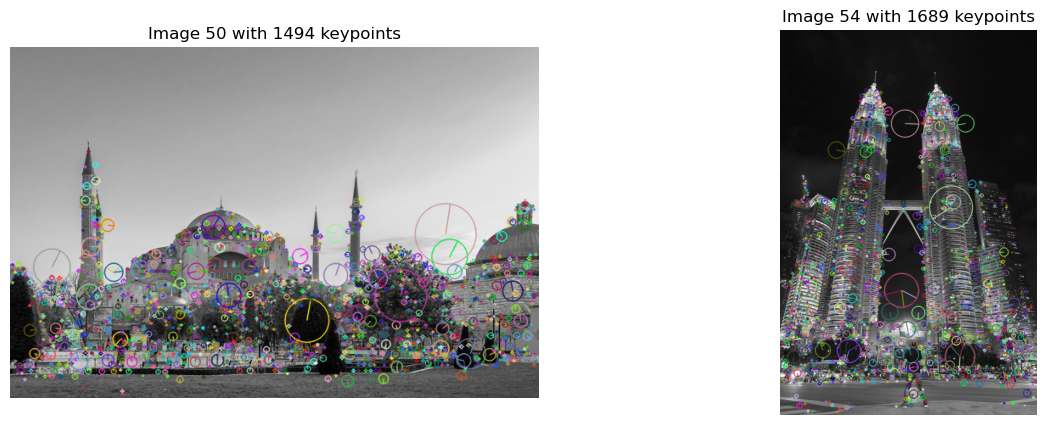

In [7]:
# OPTIONAL: JUST RUN THIS CELL, MULTIPLE TIMES TO SEE DIFFERENT IMAGES

SHOW_IN_BW = True # show images in black and white to ease the keypoint colorful visualization

output_images = []
output_info = []
for x in np.random.choice(len(images_training), 2, replace=False):
    output_image = images_training[x].copy() if not SHOW_IN_BW else cv2.cvtColor(images_training[x], cv2.COLOR_BGR2GRAY)
    output_image = cv2.drawKeypoints(output_image, keypoints[x], 0, None,
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    output_images.append(output_image)
    output_info.append([x, len(keypoints[x])])

show_images(output_images, titles=[f"Image {i+1} with {kp} keypoints" for i, kp in output_info])

The centre of each circle is the keypoint location, the line from the centre to the circle is the orientation of the keypoint, and the size of the circle is the scale at which this feature was detected.

We are now ready to build the Visual Word database!

### Building the Database

First, we want to stack the generated descriptors into a numpy array. This will be a single array of *all* the chosen descriptors across *all* the corresponding images. To be more precise, we are going to extract the corresponding keypoints, even though we are not going to use them going ahead.

In [8]:
# JUST RUN THIS CELL

all_descriptors = []
# extract image descriptor lists
for img_descriptors in descriptors:
    # extract specific descriptors within the image
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)
        
# convert to single numpy array
all_descriptors = np.stack(all_descriptors)
print(f"Extracted a total of {all_descriptors.shape[0]} descriptors of dimension {all_descriptors.shape[1]}")

Extracted a total of 117427 descriptors of dimension 128


We now want to group similar visual features (descriptors) using [k-means](https://en.wikipedia.org/wiki/K-means_clustering). After a few tests, we chose $k=200$ for our model.

After k-means, all images will be reduced to *visual words* and we will use that to build our database.

*It can be difficult to find the optimal size of our database - if too small, visual words could be not representative of all image regions, if too large, there could be too many visual words with little-no of them being shared between images (making comparisons very hard or impossible).*

Once built, the database won't change anymore, i.e., will stay fixed! The database generation can be slow (very slow, depending on *k* and the number of features), but it needs to be performed only once!

In [9]:
### YOU CAN ADJUST K AND ITERS PARAMETERS HERE IF YOU WANT
# BUT THE TUNING OF K REQUIRES SOME EXPERIMENTATION
K = 750 # number of clusters (visual words)
ITERS = 5 # number of iterations, KEEP THIS VERY LOW or IT WILL TAKE A LONG TIME
################################

# IMPORTANT: If your system is too slow in this step (>5 minutes),
# Try first reducing MAX_NUMBER_OF_PIXELS and/or SIFT_N_FEATURES in the previous cells (remember to re-run all the modified cells and the sequential cells)
# In case your system is still too slow, you can reduce K and ITERS

database, variance = kmeans(all_descriptors, K, ITERS)

100%|██████████| 5/5 [01:06<00:00, 13.28s/it]


### Building Sparse Vectors

After building our `database` we can begin building the sparse vector representations of our images, this requires three steps:
1) vector quantization
2) frequency count
3) [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf):  term frequency–inverse document frequency

#### 1. Vector quantization:

Transforming the visual *feature* representations of our images into *visual words*.

In [10]:
# JUST RUN THIS CELL

# vector quantization
from scipy.cluster.vq import vq

visual_words = []
for img_descriptors in descriptors:
    # for each image, map each descriptor to the nearest database entry
    img_visual_words, distance = vq(img_descriptors, database)
    visual_words.append(img_visual_words)

In [11]:
# JUST RUN THIS CELL

# let's see what the visual words look like for image 0
visual_words[0][:5], len(visual_words[0])

(array([ 77, 497, 110, 488, 401], dtype=int32), 2738)

*each of these values, `84`, `22`, etc., represent a centroid (visual word) from the database:*

In [12]:
# JUST RUN THIS CELL

print(database[20].shape)  # (all have the same dimensionality)
print(database[4].shape)  # (all have the same dimensionality)

(128,)
(128,)


They have dimension 128: it's the size of the SIFT descriptor.

#### 2. Frequency count

For each visual word found in the database, how often does it appear in an image? We format this as a sparse vector with frequency counts. We select the position to place a count for a visual word using the visual word identifier, e.g., position `20`.

In [13]:
# JUST RUN THIS CELL

IMAGE_IDX = 25  # choose the image index to visualize
FIRST_N_WORDS = 20  # number of visual words to display

frequency_vectors = []
for img_visual_words in visual_words:
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(K)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)
print(f"Created {frequency_vectors.shape[0]} frequency vectors of dimension {frequency_vectors.shape[1]}\n")

print(f"Image {IMAGE_IDX} frequency vector (first {FIRST_N_WORDS} visual words):")
for i in range(FIRST_N_WORDS):
    print(f"Visual word {i} present {int(frequency_vectors[IMAGE_IDX][i])} times")

Created 73 frequency vectors of dimension 750

Image 25 frequency vector (first 20 visual words):
Visual word 0 present 3 times
Visual word 1 present 3 times
Visual word 2 present 5 times
Visual word 3 present 1 times
Visual word 4 present 3 times
Visual word 5 present 5 times
Visual word 6 present 0 times
Visual word 7 present 1 times
Visual word 8 present 3 times
Visual word 9 present 0 times
Visual word 10 present 2 times
Visual word 11 present 2 times
Visual word 12 present 2 times
Visual word 13 present 6 times
Visual word 14 present 6 times
Visual word 15 present 6 times
Visual word 16 present 1 times
Visual word 17 present 3 times
Visual word 18 present 5 times
Visual word 19 present 0 times


We can also visualize the full image in a histogram like so:

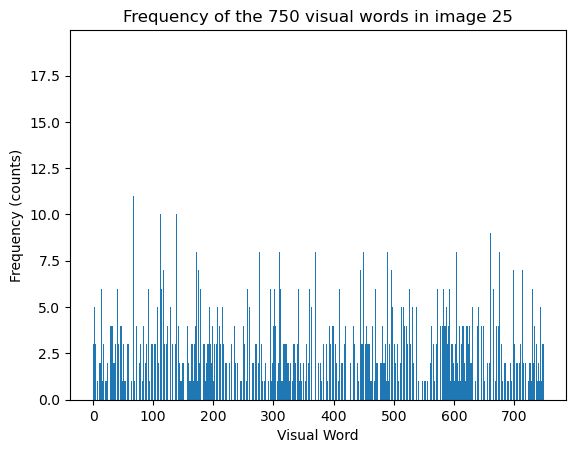

In [14]:
# JUST RUN THIS CELL

plt.bar(list(range(K)), frequency_vectors[IMAGE_IDX])
plt.title(f"Frequency of the {K} visual words in image {IMAGE_IDX}")
plt.xlabel("Visual Word")
plt.ylabel("Frequency (counts)")
plt.show()

#### 3. Tf-idf

The above histogram does not consider the relevance of the visual words. That is why, we want to re-weight them using [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (term frequency - inverse document frequency).

For reference, here is the formula. Try and refer to this if any of the following code is hard to understand.

$$tf\textrm{--}idf_{t,d} = tf_{t,d} * idf_t = tf_{t,d} * log\frac{N}{df_t}$$

where:

* $tf_{t,d}$ is the term frequency of the visual word $t$ in the image $d$ (the number of times $t$ occurs in $d$).
* $N$ is the total number of images.
* $df_t$ number of images containing visual word $t$.
* $log\frac{N}{df_t}$ measures the how common visual word $t$ is across all images in the database. This is low if the visual word $d$ occurs many times in the image, high otherwise.

Let's first calculate "*df*":

In [15]:
# JUST RUN THIS CELL

# N is the number of images, i.e. the size of the dataset
N = len(frequency_vectors)

# df is the number of images that a visual word appears in
# we calculate it by counting non-zero values as 1 and summing
df = np.sum(frequency_vectors > 0, axis=0)

In [16]:
# JUST RUN THIS CELL

VISUAL_WORD_IDX = 10  # choose the visual word index to visualize

print(f"Visual word {VISUAL_WORD_IDX} appears in {int(df[VISUAL_WORD_IDX])}/{N} images ({df[VISUAL_WORD_IDX]/N*100:.1f}%)")

Visual word 10 appears in 59/73 images (80.8%)


In [17]:
# JUST RUN THIS CELL

idf = np.where(df > 0, np.log(N/ df), 0)

print(f"Visual word {VISUAL_WORD_IDX} appears in {int(df[VISUAL_WORD_IDX])}/{N} images ({df[VISUAL_WORD_IDX]/N*100:.1f}%) : idf = {idf[VISUAL_WORD_IDX]:.4f}")

Visual word 10 appears in 59/73 images (80.8%) : idf = 0.2129


Now we move on to the full tf-idf calculation, we just multiply the *"tf"* for each image by this `idf` vector. We have already calculated the *"tf"* values, they are the frequency vectors stored in `frequency_vectors`.

In [18]:
# JUST RUN THIS CELL

tfidf = frequency_vectors * idf

print(f"Image {IMAGE_IDX} tf-idf vector (first {FIRST_N_WORDS} visual words):")
for i in range(FIRST_N_WORDS):
	print(f"Visual word {i} tf-idf: {tfidf[IMAGE_IDX][i]:.4f}")

Image 25 tf-idf vector (first 20 visual words):
Visual word 0 tf-idf: 1.0176
Visual word 1 tf-idf: 1.4514
Visual word 2 tf-idf: 1.4156
Visual word 3 tf-idf: 0.2474
Visual word 4 tf-idf: 1.2578
Visual word 5 tf-idf: 1.8922
Visual word 6 tf-idf: 0.0000
Visual word 7 tf-idf: 0.6529
Visual word 8 tf-idf: 1.5878
Visual word 9 tf-idf: 0.0000
Visual word 10 tf-idf: 0.4258
Visual word 11 tf-idf: 0.7973
Visual word 12 tf-idf: 0.9676
Visual word 13 tf-idf: 0.9800
Visual word 14 tf-idf: 1.0775
Visual word 15 tf-idf: 1.6988
Visual word 16 tf-idf: 0.2651
Visual word 17 tf-idf: 1.0176
Visual word 18 tf-idf: 0.9806
Visual word 19 tf-idf: 0.0000


Visualizing the tf-idf vector for image `IMAGE_IDX` gives use:

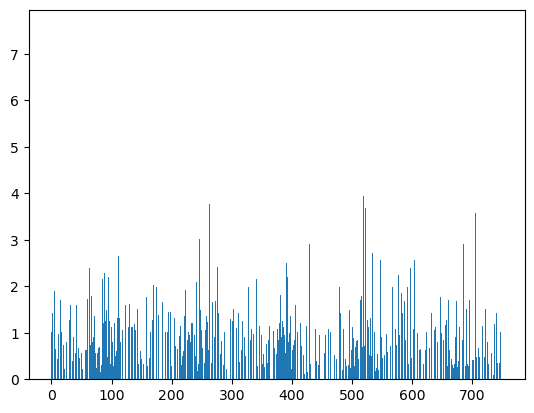

In [19]:
# JUST RUN THIS CELL

plt.bar(list(range(K)), tfidf[IMAGE_IDX])
plt.show()

### Finalizing Results

We have now generated tf-idf vectors based on the visual words of our images. To compare these images we can use a metric like *cosine similarity*.

We will use image `SEARCH_IMAGE_IDX` as our search term:

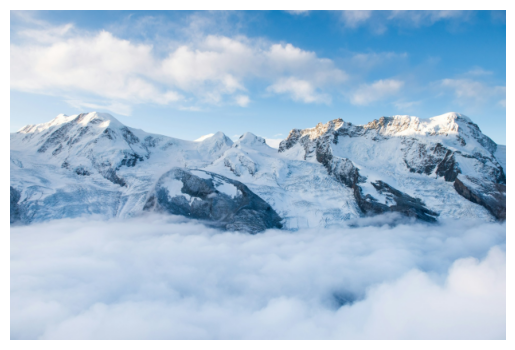

In [20]:
# JUST RUN THIS CELL

SEARCH_IMAGE_IDX = 3 # choose the image index to use as search query

show_image(images_training[SEARCH_IMAGE_IDX])

Again, for reference, our cosine similarity range is $[0,1]$, and it is calculated as follows:

$$cossim(A,B)= cos(\theta)=\frac{A \cdot B}{||A|| \space ||B||}$$

In our TF-IDF vectors, two highly similar images should be separated by a very small angular distance. Using cosine similarity, small angles output a high score (i.e., towards $1$).

In [21]:
# cosine similarity
from numpy.linalg import norm

tfidf_query = tfidf[SEARCH_IMAGE_IDX]
tfidf_database = tfidf  # set search space to the full sample

cosine_similarity = np.dot(tfidf_query, tfidf_database.T)/(norm(tfidf_query) * norm(tfidf_database+0.00001, axis=1))
print("Cosine similarity of the database relative to search image:", cosine_similarity)
print("Min cosine similarity:", round(np.min(cosine_similarity),1))
print("Max cosine similarity:", np.max(cosine_similarity))

Cosine similarity of the database relative to search image: [0.48813039 0.39118678 0.33358332 0.99998947 0.52708563 0.56939474
 0.5113492  0.5716119  0.59679577 0.61493136 0.37222926 0.54899718
 0.42530242 0.58513549 0.5846333  0.23274133 0.44545114 0.38952446
 0.26326074 0.33529964 0.19591804 0.38921068 0.44401353 0.38869691
 0.24307495 0.48008394 0.24824976 0.30585321 0.23456579 0.40166252
 0.46424975 0.3808978  0.31605842 0.46618727 0.31861545 0.36483984
 0.39999175 0.38637071 0.4205967  0.37946646 0.37618433 0.47089223
 0.53227762 0.4230832  0.53283346 0.46833641 0.47785521 0.49599049
 0.46049211 0.45972561 0.40471812 0.52654239 0.12777981 0.16867389
 0.05277222 0.18477358 0.31090899 0.02391889 0.06541697 0.03418114
 0.056772   0.05025992 0.36984272 0.23469727 0.29751929 0.33365613
 0.52524046 0.29265339 0.40769573 0.34443334 0.23350703 0.32718567
 0.34006559]
Min cosine similarity: 0.0
Max cosine similarity: 0.9999894677745316


To find the `top_k` most similar items, we use Numpy's `argpartition`.

In [22]:
# JUST RUN THIS CELL

TOP_K_RESULTS = 3
idx = np.argsort(-cosine_similarity)[:TOP_K_RESULTS]
print(f"The top {TOP_K_RESULTS} most similar images are at indices: {idx}")

The top 3 most similar images are at indices: [3 9 8]


The first image in the array should correspond to the image itself. Therefore, the cosine similarity must be $≅1$.

In [23]:
# JUST RUN THIS CELL

cosine_similarity[idx[0]]

0.9999894677745316

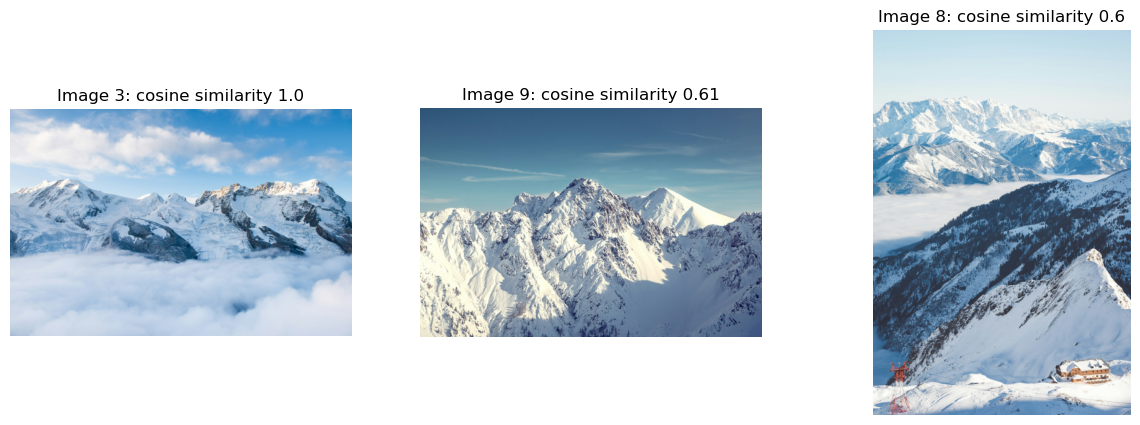

In [24]:
output_images = []
output_info = []
for i in idx:
    output_images.append(images_training[i])
    output_info.append(f"Image {i}: cosine similarity {round(cosine_similarity[i], 2)}")

show_images(output_images, titles=output_info)

This looks promising, now we can try to extract features from the query image, and to find the most similar images in the database.

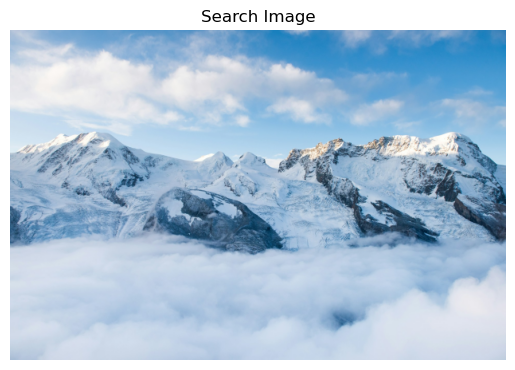

-----------------------------------------------------
Extracted 964 keypoints from search image
(964,) (964,)


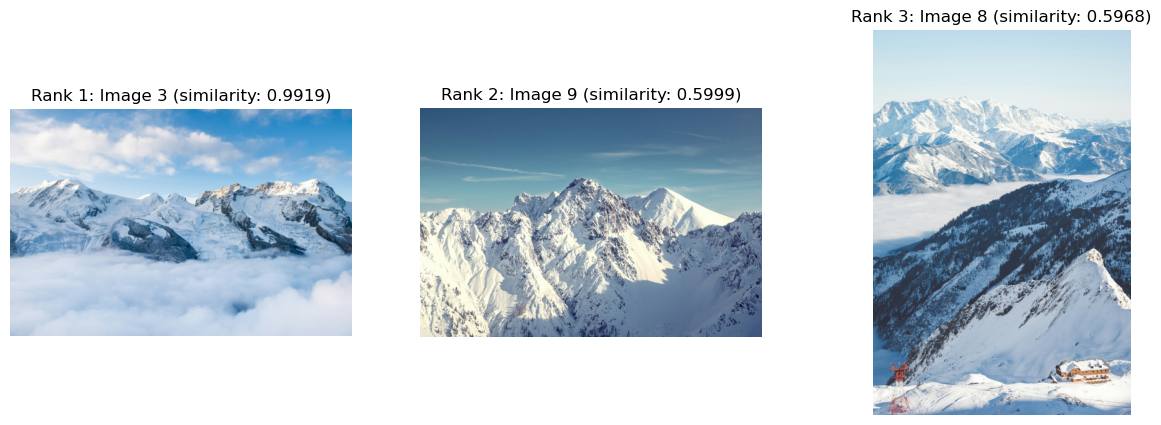

In [ ]:

TOP_K_RESULTS = 3

# TODO: detect keypoints and compute descriptors using SIFT
# check opencv documentation for SIFT: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
def TODO_extract_features(image: np.ndarray):
	# use the already initialized sift_extractor:
	# query_keypoints, query_descriptors = sift_extractor.XXX(...)
	raise NotImplementedError("TODO: implement this function to extract SIFT keypoints and descriptors")
    # return query_keypoints, query_descriptors

def get_cosine_similarity(tfidf_query: np.ndarray, tfidf_database: np.ndarray):
	cosine_similarity = np.dot(tfidf_query, tfidf_database.T)/(norm(tfidf_query) * norm(tfidf_database, axis=1))
	return cosine_similarity


###########################################


def search(image: np.ndarray, top_k: int = TOP_K_RESULTS):
	# show the search image
	show_image(image, title=f"Search Image")
	print("-----------------------------------------------------")
	
	# Step 1: Feature extraction - extract SIFT keypoints and descriptors from the query image
	query_keypoints, query_descriptors = TODO_extract_features(image)
	print(f"Extracted {len(query_keypoints)} keypoints from search image")

	# Step 2: Vector quantization - map query descriptors to visual words
	query_visual_words, distances = vq(query_descriptors, database)
	print(distances.shape, query_visual_words.shape)
	
	# Step 3: Frequency count - create frequency vector for query image
	query_frequency_vector = np.zeros(K)
	for word, distance in zip(query_visual_words, distances):
		query_frequency_vector[word] += 1 * 1/max(distance, 1)

	# Step 4: TF-IDF - multiply frequency vector by pre-computed idf
	tfidf_query = query_frequency_vector * idf

	# Step 5: get the cosine distance for the query image
	cosine_similarity = get_cosine_similarity(tfidf_query, tfidf)

	# Step 6: get the top k indices for most similar vecs
	idx = np.argsort(-cosine_similarity)[:top_k]

	# display the results
	output_images = []
	output_info = []
	for j, img_idx in enumerate(idx):
		output_images.append(images_training[img_idx])
		output_info.append(f"Rank {j+1}: Image {img_idx} (similarity: {round(cosine_similarity[img_idx], 4)})")

	show_images(output_images, titles=output_info)

search(images_training[SEARCH_IMAGE_IDX])

We are using for the query image a simple training image used to build the database. As we have seen, it has cosine similarity ≃ 1 with itself.

Now we are ready to modify an image from the database to make the image retrieval more difficult.

We can modify the image by applying brightness and homography tranformations (warping). You can also try to query the database using an image you download online.

**But remember that this is a simple demo and its performance is limited.**

In [26]:
### PLAY WITH THE PARAMETERS BELOW TO MODIFY THE QUERY IMAGE
# But if you make too strong modifications, the retrieval may fail!
# Remember that this is a simple demo and its performance is limited
BRIGHTNESS_ALPHA_FACTOR = 0.8
BRIGHTNESS_BETA_FACTOR = 0
ROTATE_ANGLE = 0  # degrees
SHEAR_X = -150
SHEAR_Y = 50
SCALE = 0.8
TRANSLATE_X = 20
TRANSLATE_Y = -40
#####################################

def modify_image(image_input: np.ndarray) -> np.ndarray:
	image = image_input.copy()
	image = cv2.convertScaleAbs(image, alpha=BRIGHTNESS_ALPHA_FACTOR, beta=BRIGHTNESS_BETA_FACTOR)
	image = warp_perspective(image, rot_deg=ROTATE_ANGLE, shear_x=SHEAR_X, shear_y=SHEAR_Y, scale=SCALE, tx=TRANSLATE_X, ty=TRANSLATE_Y)
	return image

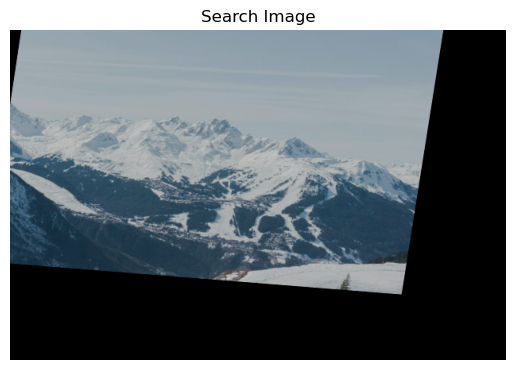

-----------------------------------------------------
Extracted 856 keypoints from search image
(856,) (856,)


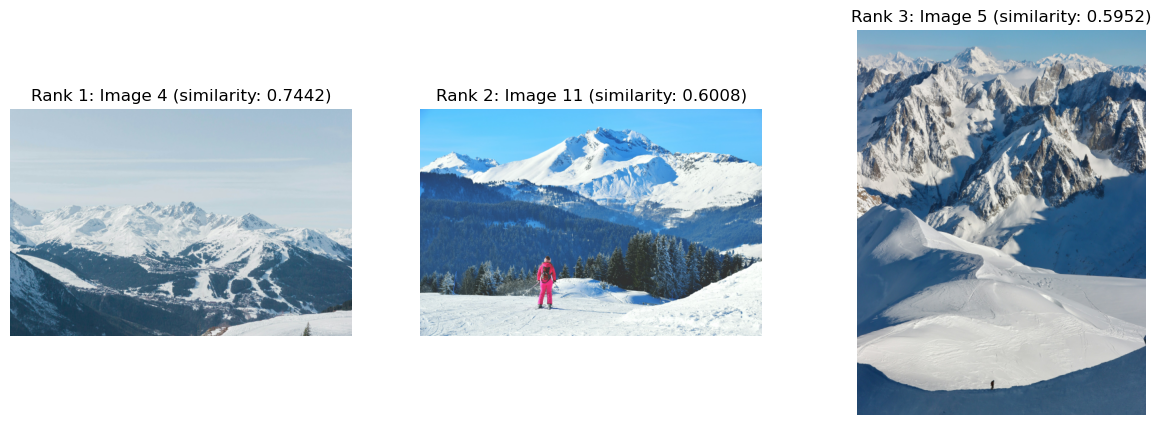

In [27]:
search(modify_image(images_training[4]))

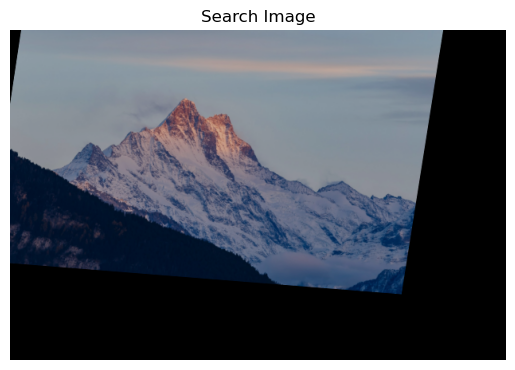

-----------------------------------------------------
Extracted 621 keypoints from search image
(621,) (621,)


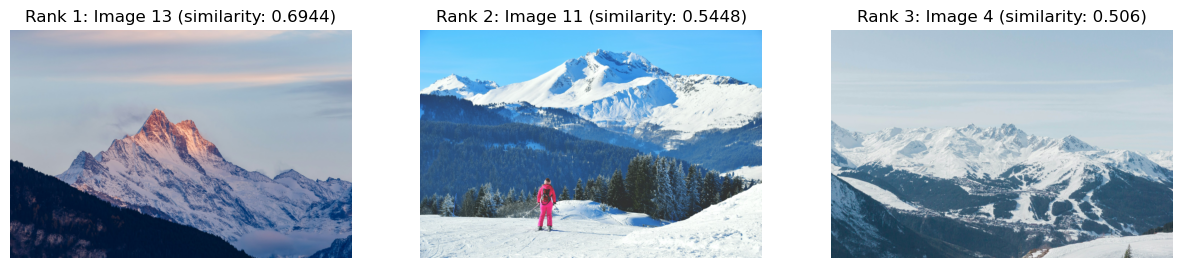

In [28]:
search(modify_image(images_training[13]))

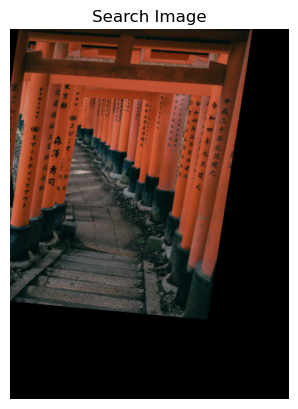

-----------------------------------------------------
Extracted 980 keypoints from search image
(980,) (980,)


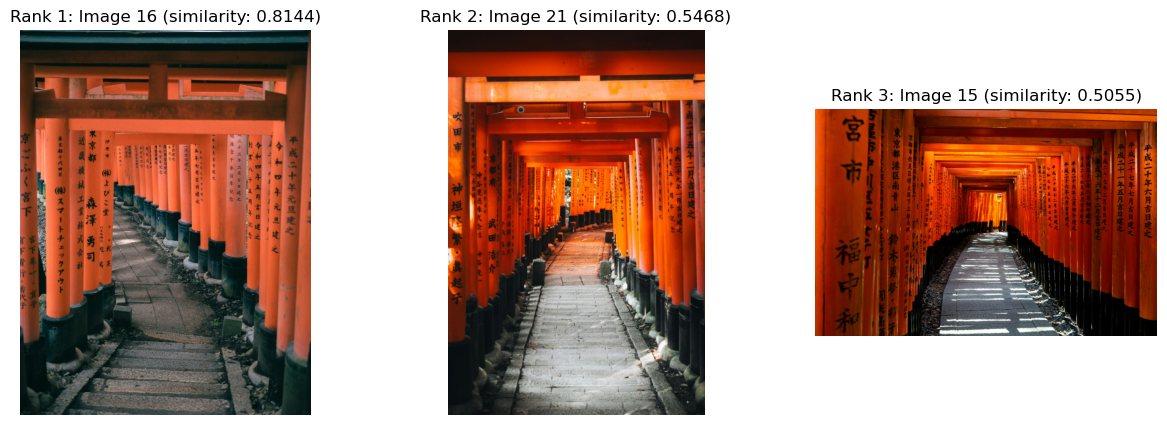

In [29]:
search(modify_image(images_training[16]))

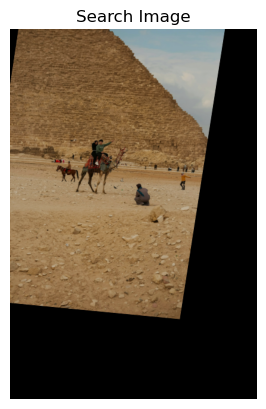

-----------------------------------------------------
Extracted 822 keypoints from search image
(822,) (822,)


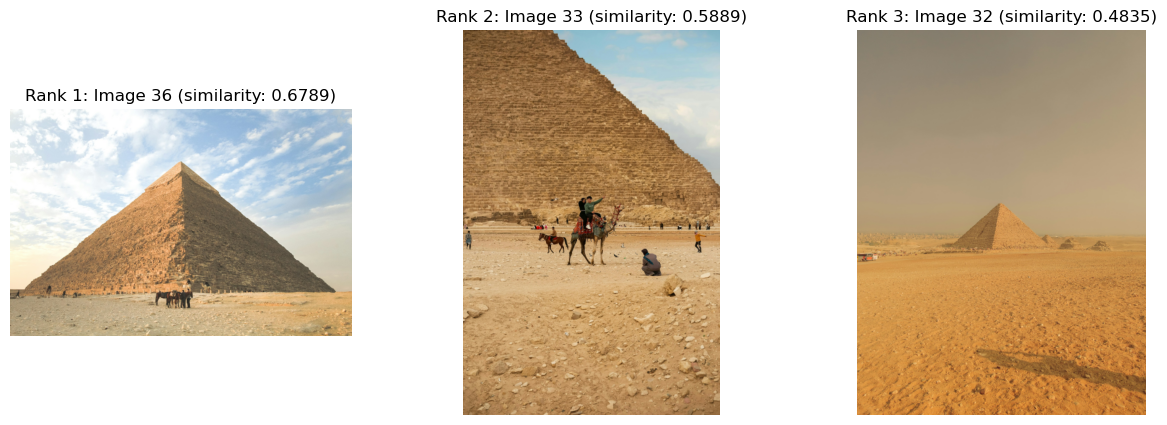

In [30]:
search(modify_image(images_training[33]))

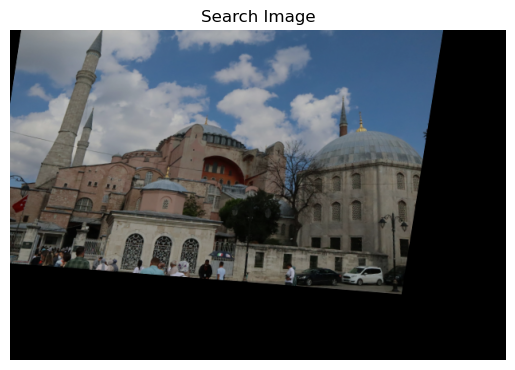

-----------------------------------------------------
Extracted 1204 keypoints from search image
(1204,) (1204,)


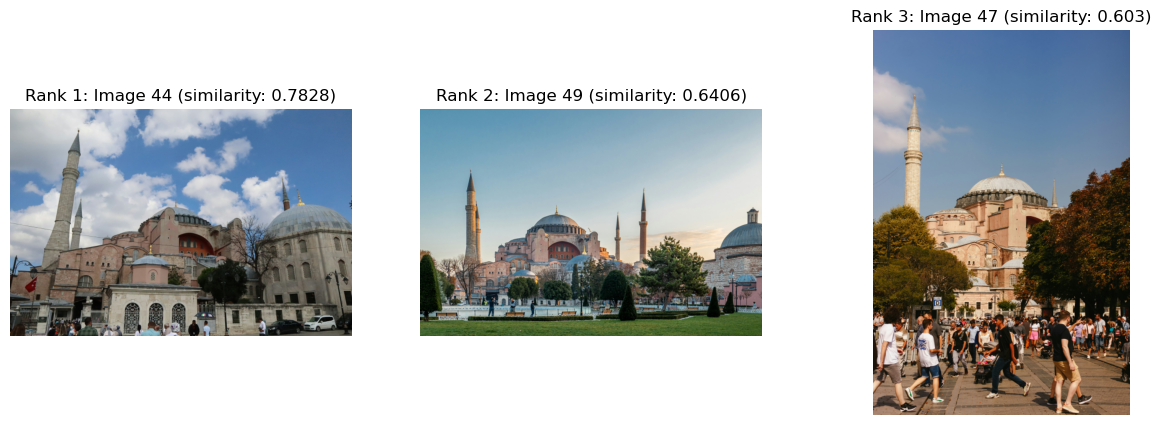

In [31]:
search(modify_image(images_training[44]))

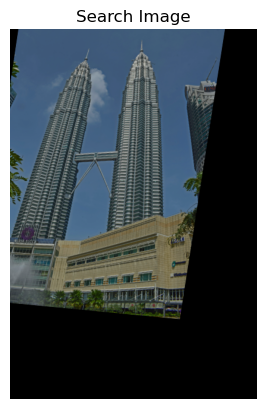

-----------------------------------------------------
Extracted 1791 keypoints from search image
(1791,) (1791,)


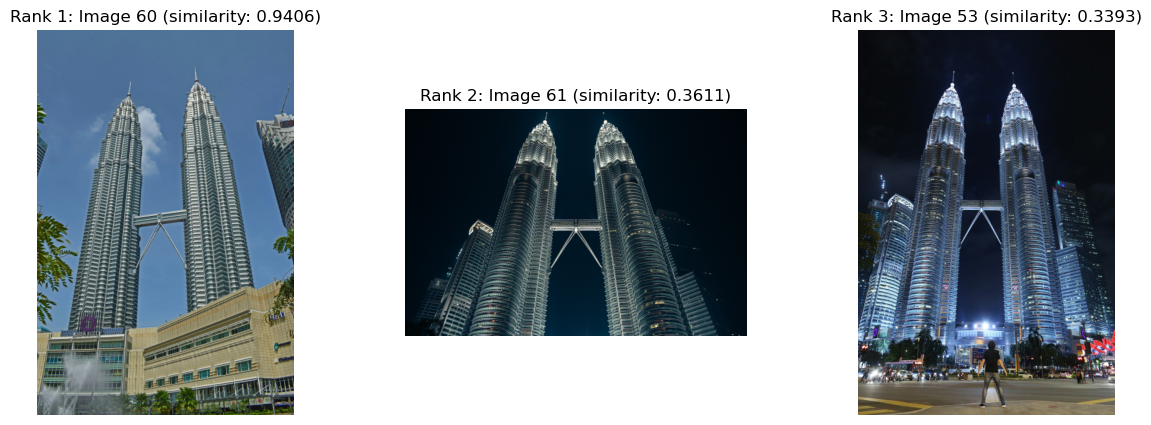

In [32]:
search(modify_image(images_training[60]))

---

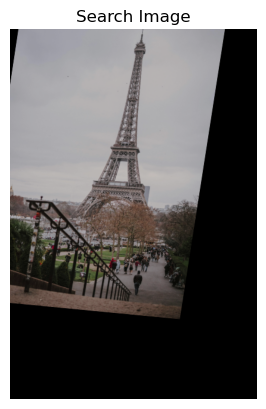

-----------------------------------------------------
Extracted 970 keypoints from search image
(970,) (970,)


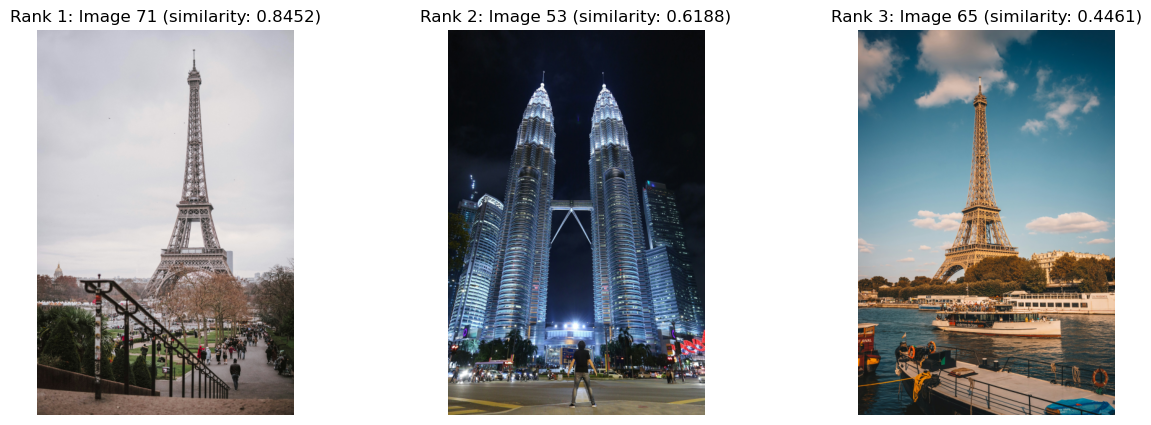

In [33]:
search(modify_image(images_training[71]))

The results are not always perfect, but for the most part it should manage in returning similar images. You can try to improve its accuracy by modifying the SIFT exctractor parameters, or the K number of clusters to use.